# Train the GAN

In [1]:
import tensorflow as tf
tf.__version__
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

2023-09-19 17:22:37.693996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 17:22:38.028952: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 17:22:39.403131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-09-19 17:22:39.403597: W tensorflow/comp

## Load Dataset

2023-09-19 17:22:43.211020: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-19 17:22:43.211072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (himalaya-fon): /proc/driver/nvidia/version does not exist
2023-09-19 17:22:43.211756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(1540, 40, 120, 1)


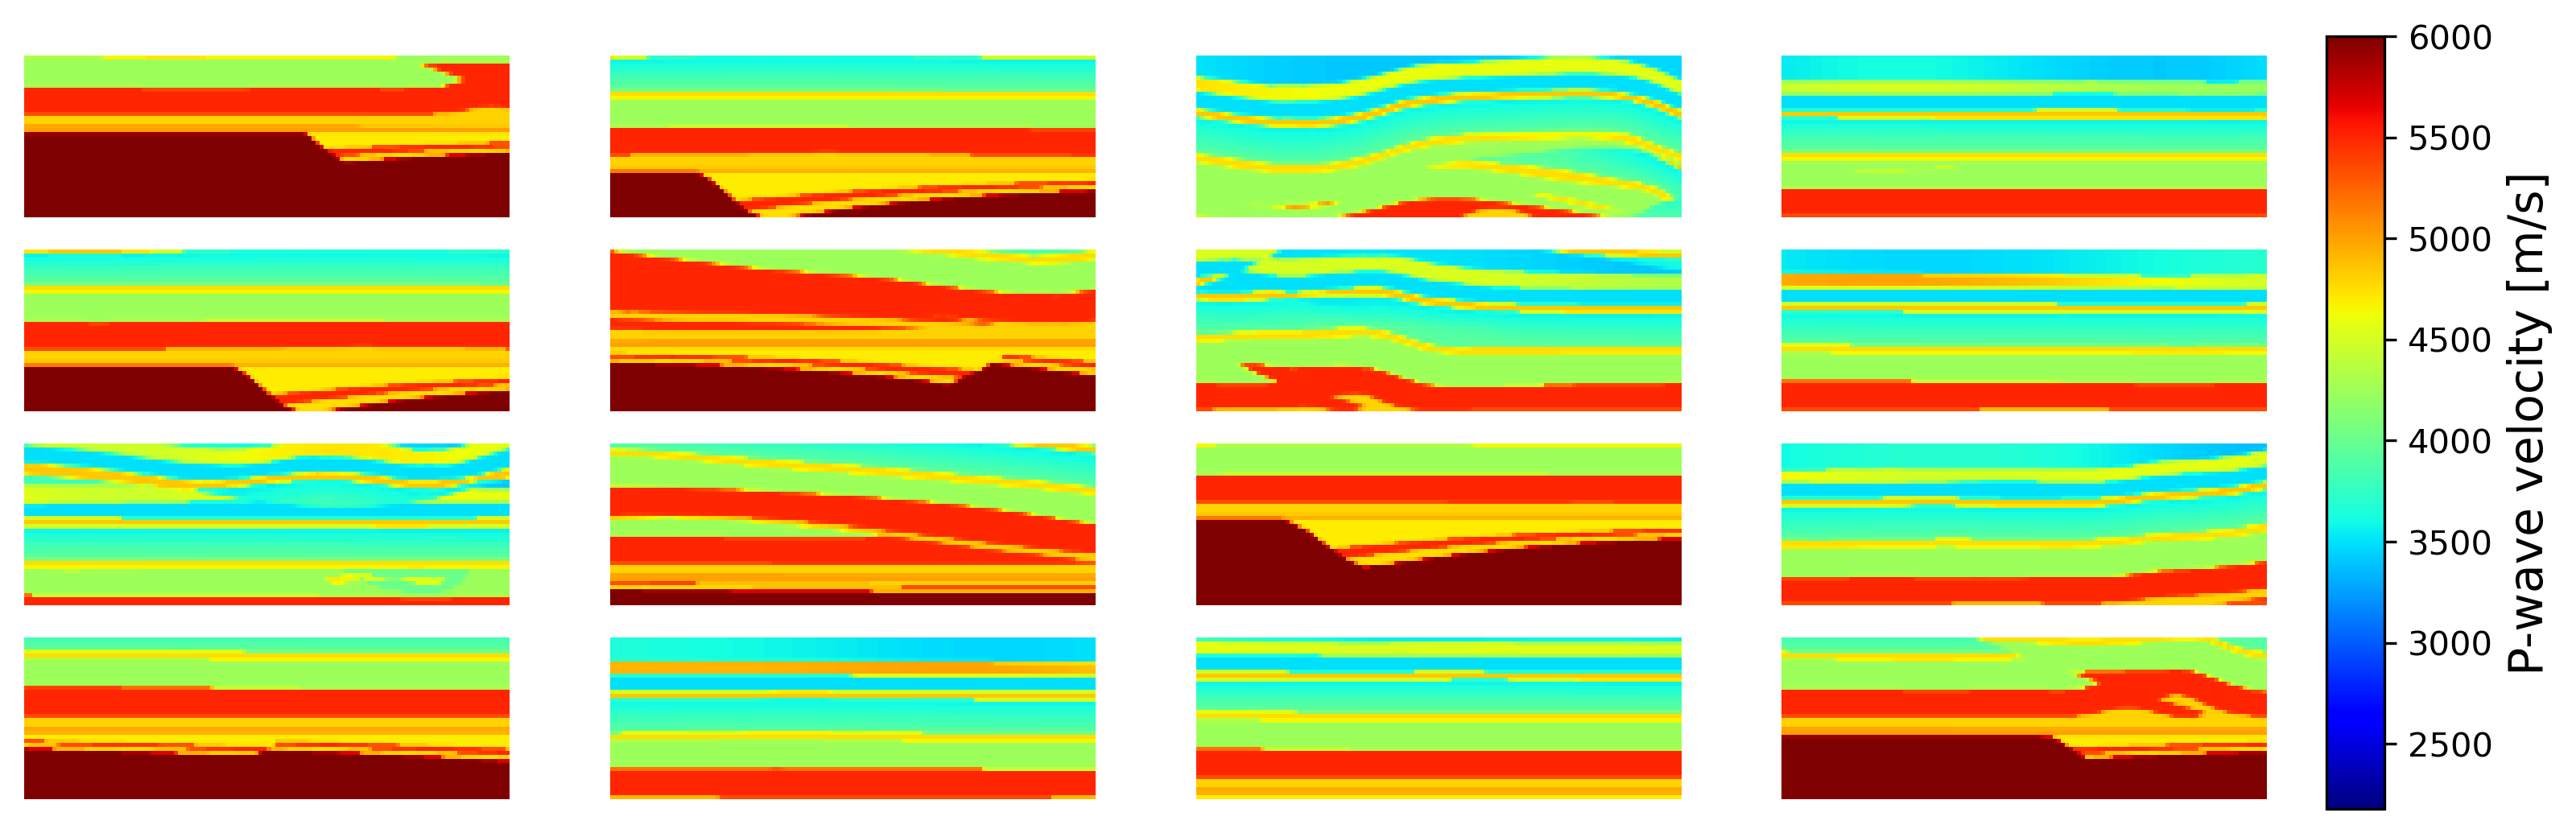

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import requests

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# n1= 93 n2=401 n3=401 d1=d2=d3=50m
vel = readbin('../dataset/overthrust.bin',93,401*401)

vel = np.reshape(vel,[93,401,401])
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape

    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])

    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//4 # Interval on x-axis
y_interval = crop_size[1]//4  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 4), dpi=300)
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(cropped_images[np.random.randint(n_img),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()


## Normalize images

In [3]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 20
dim_z=100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-1.0 0.9999999


## Define Generator and Discriminator

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

kernal_size = (5, 5)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 4),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  plt.savefig('./dcgan/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model

tf.Tensor([[-0.00019298]], shape=(1, 1), dtype=float32)


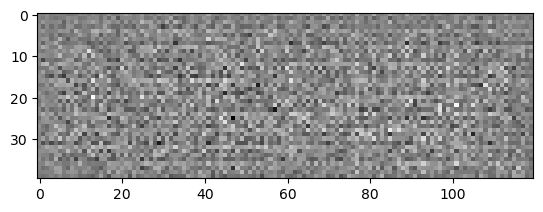

In [5]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

checkpoint_dir = './dcgan/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50
noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

restore = True
if restore==True: checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else: train(train_dataset, EPOCHS)

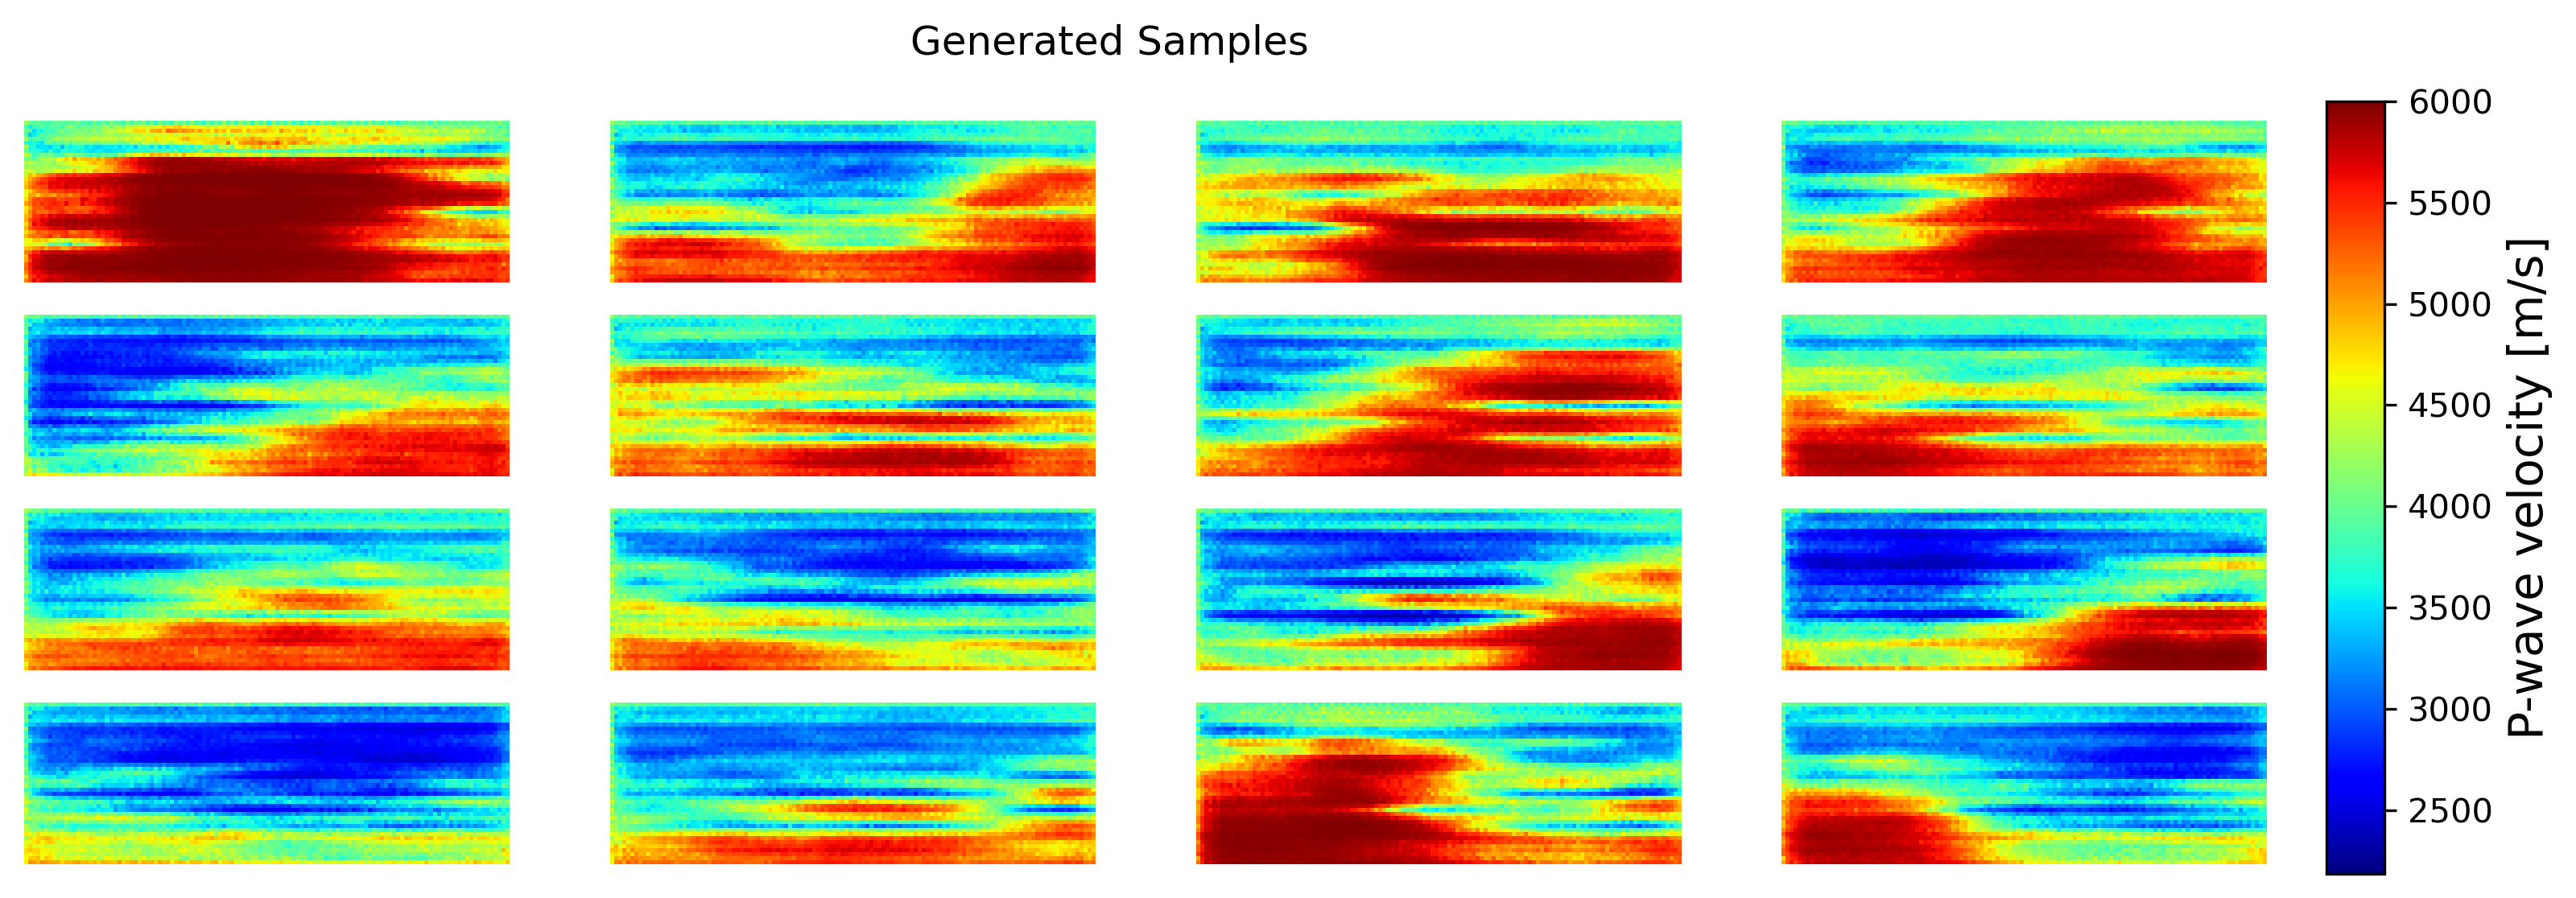

In [6]:
noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
fig = plt.figure(figsize=(12, 4),dpi=300)
plt.suptitle("Generated Samples")
for i in range(num_examples_to_generate):
  plt.subplot(4, 4, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
plt.show()

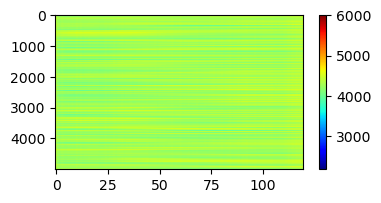

In [19]:
noise_dim = dim_z
num_examples_to_generate = 5000
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
Gz_mean = tf.reduce_mean(inverse_norm(Gz[:,:,:,0],vmin,vmax), axis=1)


plt.figure(figsize=(4,2))
plt.imshow(Gz_mean,cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
plt.colorbar()
plt.show()

# Customized layer

## Forward Modeling With TensorFlow adjoint function

In [7]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from IPython.display import clear_output
import numpy as np
import cupy as cp
import cupyx
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model
from func.velocity_model import gaussian2d
from joblib import Parallel, delayed

precision = np.float64
device = 'cpu'


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()

def l2_loss(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next):
	
    nsrc = zxsrc.shape[1]
    Js = 0
    for i in range(nsrc):
        zxsrci = np.expand_dims(zxsrc[:,i],-1)
        nz, nx = len(az), len(ax)
        _, d = prop2d_tf(wsrc, zxsrci, zxrec, vel, at, az, ax, next)
        residual = d - d_obs[i]
        J = 0.5 * tf.reduce_sum(residual ** 2) # Residual is the half of the L2 norm square
        Js += J
    print("J = %.2f" % Js)

    return Js

@tf.function
def idx_to_replace(z1,z2,x1,x2):
  tf.config.run_functions_eagerly(True)
  arr = []
  for i in tf.range(z1,z2):
    for j in tf.range(x1,x2):
      arr.append([i,j])
  return arr

@tf.function
def replace(tensor,arr,iz,ix):
  """
  tensor: tensor to replace the elements
  arr: the array to insert
  iz,ix: the index of z and x
  """
  replaced = tf.tensor_scatter_nd_update(
          tensor, 
  idx_to_replace(iz[0],iz[1],ix[0],ix[1]),
  tf.reshape(arr, [-1]))
  return replaced

@tf.function
def prop2d_tf(wsrc, zxsrci, zxrec, vel, at, az, ax, next):
  wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc)
# for i in range (1):
  nabs  = tf.constant(10)
  next2 = nabs + next
  nt    = tf.size(at)
  nz    = tf.size(az)
  nx    = tf.size(ax)
  vel = tf.reshape(vel,[nz,nx])
  az = tf.convert_to_tensor(az,dtype="float32")
  ax = tf.convert_to_tensor(ax,dtype="float32")
  at = tf.convert_to_tensor(at,dtype="float32")
  dz    = az[1] - az[0]
  dx    = ax[1] - ax[0]
  dt    = at[1] - at[0]   
  _dz2   = 1./dz**2
  _dx2   = 1./dx**2
  # Extend the model
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  size = nze * nxe

  #########################  EXTEND MODEL ########################
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  vele = tf.zeros([nze,nxe],dtype="float32")

  # velnp = tf.convert_to_tensor(vel.numpy()) # creat velnp to stop recording
  velnp = vel
  # Top and bottom
  vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
                  [0,next2],[next2,nxe-next2])
  vele = replace(vele,tf.repeat([velnp[-1,:]],next2,axis=0),
          [nze-next2,nze],[next2,nxe-next2]) 
  # Left and right
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,0]],next2,axis=0)),
          [next2,nze-next2],[0,next2])
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,-1]],next2,axis=0)),
          [next2,nze-next2],[nxe-next2,nxe])
  # Corners
  vele = replace(vele,tf.fill([next2, next2], velnp[0,0]),
          [0,next2],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[0,-1]),
          [0,next2],[nxe-next2,nxe])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,0]),
          [nze-next2,nze],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,-1]),
          [nze-next2,nze],[nxe-next2,nxe])
  # Central part
  vele = replace(vele,vel,[next2,nze-next2],[next2,nxe-next2])
  ###############################################################

  vele = tf.reshape(vele,[-1])

  # Center Part (Laplacian)
  mask0 = np.full((nze, nxe), 0, dtype=np.float32)
  mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = 1
  mask0 = tf.convert_to_tensor(mask0.flatten())

  # Construct the Laplacian matrix
  fact = (dt * vele)**2

  # Set values for interior points
  diagonal = (2*tf.ones(size) + fact*(-2*tf.ones(size)*(_dz2+_dx2))) * mask0
  off_diagonal_x_left = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_x_right = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_z_left = (fact*tf.ones(size) * _dx2) * mask0     #
  off_diagonal_z_right = (fact*tf.ones(size) * _dx2) * mask0    #

  # Calculate factors for boundary conditions
  factz = (-dt/dz) * vele
  factx = (-dt/dx) * vele

  # Bottom part
  mask1 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask1[nze-1-nabs:nze,:nxe] = 1
  mask1[nze-1-nabs:nze,1+nabs:nxe-1-nabs] = 1   # Modified to avoid duplication on corners
  mask1 = tf.convert_to_tensor(mask1.flatten())
  diagonal += (1 + factz) * mask1
  off_diagonal_z_left += -factz * mask1

  # Top part
  mask2 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask2[:1+nabs,:nxe] = 1
  mask2[:1+nabs,1+nabs:nxe-1-nabs] = 1          # Modified to avoid duplication on corners
  mask2 = tf.convert_to_tensor(mask2.flatten())
  diagonal += (1 + factz) * mask2
  off_diagonal_z_right += -factz * mask2

  # Right part
  mask3 = np.full((nze, nxe), 0, dtype=np.float32)
  mask3[:nze,nxe-1-nabs:nxe] = 1        
  mask3 = tf.convert_to_tensor(mask3.flatten())
  diagonal += (1 + factx) * mask3
  off_diagonal_x_left += -factx * mask3

  # Left part
  mask4 = np.full((nze, nxe), 0, dtype=np.float32)
  mask4[:nze,:1+nabs] = 1
  mask4 = tf.convert_to_tensor(mask4.flatten())
  diagonal += (1 + factx) * mask4
  off_diagonal_x_right += -factx * mask4

  # Combine the diagonals to create a COO representation of the sparse matrix
  # Diagonal indices [[0,0],[1,1]...[size,size]]
  diag_idx = np.linspace((0,0),(size-1,size-1),size,dtype=int) 

  indices = np.vstack((diag_idx,                          # Diagonal
                        diag_idx[1:] + [[0,-1]],           # Off-diagonal_x_left
                        diag_idx[nxe:] + [[0,-nxe]],       # Off-diagonal_z_left
                        diag_idx[:size-nxe] + [[0,nxe]],   # Off-diagonal_z_left
                        diag_idx[:size-1] + [[0,1]]))      # Off-diagonal_x_right
  
  values = tf.concat([diagonal,                           # Diagonal
                      off_diagonal_x_left[1:],            # Off-diagonal_x_left
                      off_diagonal_z_left[nxe:],          # Off-diagonal_z_left
                      off_diagonal_z_right[:size-nxe],     # Off-diagonal_z_right
                      off_diagonal_x_right[:size-1]],0)    # Off-diagonal_x_right

  A = tf.SparseTensor(indices=indices, values=values, dense_shape=(size, size))   

  # Wavefield p mask (initial center part)
  maskp = np.full((nze, nxe), False)
  maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = True
  maskp = tf.convert_to_tensor(maskp.flatten())
  mask0_bool = tf.cast(mask0,bool)

  pm = tf.zeros(size) # Previous wave field
  pt = tf.zeros(size)
  pp = tf.zeros(size)

  p = [tf.zeros(nz*nx)]
  p.append(tf.zeros(nz*nx))

  dobs = tf.zeros((zxrec.shape[1],2))

  srcsteps = wsrc.shape[1] # Determine the time steps of the source
  for it in range(1,nt-1): # From 1 to nt-1
  # for it in range(1,nt-1): # From 1 to nt-1
    pm = pt
    pt = pp
    if it<srcsteps:
      cen = np.zeros((nz,nx))
      cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
      asrcit = np.pad(cen, next2, mode='constant').flatten()
      asrcit = tf.convert_to_tensor(asrcit, dtype=tf.float32)
      srcterm = asrcit*fact*mask0
    else: srcterm = tf.zeros(size)

    # pp = A.dot(pt) - pm*mask0 + srcterm
    laplacien = tf.reshape(tf.sparse.sparse_dense_matmul(A, tf.reshape(pt, [-1, 1])),[-1])
    pp = laplacien - pm*mask0 + srcterm
    p.append(tf.boolean_mask(pp,maskp))

    # Concat observation at receivers locations
    dobsi = tf.gather_nd(tf.reshape(tf.boolean_mask(pp,maskp),[nz,nx]),tf.transpose(zxrec))
    dobsi = tf.reshape(dobsi,[-1,1])
    dobs = tf.concat([dobs,dobsi],1)
  
  # Calculate J here
  p = tf.convert_to_tensor(p, dtype=tf.float32)
  p = tf.transpose(p, perm=[1, 0])
  # residual = dobs - tf.convert_to_tensor(d_obs, dtype=tf.float32)
  # J = 0.5 * tf.reduce_sum(residual ** 2)

  return p, dobs

@tf.function
def second_order_derivative_tf(p, at, az, ax):
  """
  Calculate second order derivative for p(z,x,t)
  method: finite-difference
  """
  # extend model to tmin=0 tmax=0 -- insert zeros in dimension t
  nz, nx = len(az), len(ax)
  dt = at[1] - at[0]
  # Assign 0.0 to the first and last column
  p = replace(p, tf.zeros([nz*nx]),[0,nz*nx],[0,1])
  p = replace(p, tf.zeros([nz*nx]),[0,nz*nx],[nt-1,nt])
  _dt2 = 1./dt**2
  # Calculate second order derivative using vectorized operations
  p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
  # # Insert zeros at boundaries using array views
  p_dt_dt = tf.concat([tf.zeros([nz * nx, 1]), p_dt_dt, tf.zeros([nz * nx, 1])], axis=1)

  return p_dt_dt

@tf.function
def gradient_tf(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next):
  """
  Calculate gradiant using adjoint state method
  """
  vel = tf.reshape(vel,[-1])
  nsrc = zxsrc.shape[1]
  grads = tf.zeros_like(vel)
  for i in range(nsrc):
    print('Source', i, end='...   ')
    zxsrci = tf.expand_dims(zxsrc[:,i],-1)
    p_fwd, d = prop2d_tf(wsrc,zxsrci,zxrec,vel,at,az,ax,next)
    residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
    # Calculate back propagated p_back(z,x,t)
    p_back, _ = prop2d_tf(tf.reverse(residual,axis=[1]), zxrec, zxsrci, vel, at, az, ax, next)
    p_back = tf.reverse(p_back,axis=[1])
    # Calculate second order time derivative of p_fwd(z,x,t)
    p_dt_dt = second_order_derivative_tf(p_fwd, at, az, ax)
    # Calculate gradiant
    grad = 2/vel**3  * tf.reduce_sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
    grads += grad

  return tf.reshape(grads,[-1])

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,400
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

# Read the original input data
# vel   = readbin('../dataset/marm2_sel.dat',nz,nx)[1:,1:]
# vel = vel[::5,::5]
# v_ref = vel * 1e3

# Choose reference velocity field from dataset
v_ref = cropped_images[500,:,:,0].numpy()
nz,nx = 40, 120

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# vmin,vmax = v_ref.min(),v_ref.max()

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.arange(0,nx)
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

# zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
zxsrc = np.array([[1], [3*nx//6]])
nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop2d_tf(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next)
  d_obs.append(d_obs_i)

plt.figure(figsize=(10,3), dpi=300)
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
cbar = plt.colorbar()
cbar.formatter.set_useMathText(True)
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
cbar.update_ticks()
cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
plt.legend(loc='upper right',fontsize=labelsize-8)
plt.xlabel('Distance [m]', fontsize=labelsize-4)
plt.ylabel('Depth [m]', fontsize=labelsize-4)
plt.title("a) True velocity model",fontsize=labelsize)

plt.subplot(1,2,2)
plt.imshow(tf.transpose(d_obs[0]),cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
cbar = plt.colorbar()
cbar.set_label("Amplitude")
plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
plt.ylabel('Time [s]', fontsize=labelsize-4)
plt.tight_layout()
plt.show()

Min velocity: 3795.81  Max velocity 5500.00
dz,dx,dt (m): 8.738276367187499 8.738276367187499 0.0009268341712680645
Model dimension [nz,nx,nt]:  40 120 400


AttributeError: in user code:

    File "/tmp/ipykernel_9891/3663966451.py", line 130, in prop2d_tf  *
        wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc)

    AttributeError: 'Tensor' object has no attribute 'ndim'


In [ ]:
# Generate a new image
noise_dim = dim_z
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
v_gan = Gz.numpy().reshape((nz,nx))

# Calculate gradient of v_gan
grad = gradient_tf(v_gan,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next)

Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   

In [ ]:
conditional_generator = tf.keras.models.clone_model(generator)  # Clone generator
conditional_generator.set_weights(generator.get_weights()) # Clone weights
conditional_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 76800)             7680000   
                                                                 
 batch_normalization (BatchN  (None, 76800)            307200    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 76800)             0         
                                                                 
 reshape (Reshape)           (None, 10, 30, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 30, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 10, 30, 128)      5

## Conditional Generator

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Assuming 'conditional_generator' is your cloned generator
conditional_generator = tf.keras.models.clone_model(generator)
conditional_generator.set_weights(generator.get_weights())

@tf.function  # Add this decorator to force eager execution
def custom_loss(vel):
    loss = l2_loss(vel, d_obs, wsrc, zxsrc, zxrec, at, az, ax, next)
    return loss

@tf.function  # Add this decorator to force eager execution
def custom_gradient(vel):
    grad = gradient_tf(vel, d_obs, wsrc, zxsrc, zxrec, at, az, ax, next)
    return tf.reshape(grad, [nz, nx])

# Create a custom layer to update the conditional generator's weights
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, custom_gradient_fn, learning_rate=0.01):
        super(CustomLayer, self).__init__()
        self.custom_gradient_fn = custom_gradient_fn
        self.learning_rate = learning_rate

    def call(self, v):
        # Calculate the custom gradient using the provided custom_gradient_fn
        gradient = self.custom_gradient_fn(v)

        # Update the conditional generator's weights using gradient ascent
        generator_weights = self.parent_layer.trainable_weights
        for i in range(len(generator_weights)):
            # Ensure the shape of the gradient matches the weights
            gradient_shape = gradient[i].shape
            gradient_as_int = tf.shape(gradient[i])[0]
            generator_weights[i].assign_add(self.learning_rate * gradient_as_int)

        return v

# Create an instance of the custom gradient layer
custom_gradient_layer = CustomLayer(custom_gradient, learning_rate=0.01)

# Add the custom gradient layer to the end of the conditional generator
conditional_generator.add(custom_gradient_layer)

# # Example usage within a training loop
# num_epochs = 5
# for epoch in range(num_epochs):
#     # Forward pass: Generate v using the conditional generator
#     noise = tf.random.normal([BATCH_SIZE, dim_z])
#     v = conditional_generator(noise, training=True)  # Adjust input_data based on your needs

#     # Calculate the custom loss
#     loss = custom_loss(v)

#     # Backpropagate through the custom layer to update the conditional generator's weights
#     v = conditional_generator.layers[-1](v)

#     # Print or log the loss for monitoring the training progress
#     print(f"Epoch {epoch + 1}, Loss: {loss}")


Source 0...   

OperatorNotAllowedInGraphError: Exception encountered when calling layer "custom_layer_27" (type CustomLayer).

in user code:

    File "/tmp/ipykernel_13282/665067793.py", line 27, in call  *
        gradient = self.custom_gradient_fn(v)
    File "/tmp/ipykernel_13282/665067793.py", line 15, in custom_gradient
        grad = gradient_tf(vel, d_obs, wsrc, zxsrc, zxrec, at, az, ax, next)
    File "/tmp/ipykernel_13282/3663966451.py", line 327, in gradient_tf
        p_fwd, d = prop2d_tf(wsrc,zxsrci,zxrec,vel,at,az,ax,next)
    File "/tmp/ipykernel_13282/3663966451.py", line 159, in prop2d_tf
        vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
    File "/tmp/ipykernel_13282/3663966451.py", line 124, in replace
        idx_to_replace(iz[0],iz[1],ix[0],ix[1]),
    File "/tmp/ipykernel_13282/3663966451.py", line 110, in idx_to_replace
        for i in tf.range(z1,z2):

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.


Call arguments received by layer "custom_layer_27" (type CustomLayer):
  • v=tf.Tensor(shape=(None, 40, 120, 1), dtype=float32)

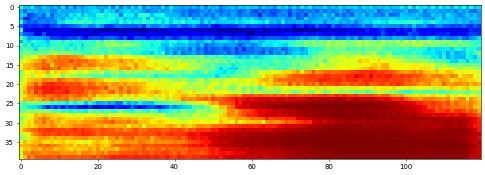

In [ ]:
seed = tf.random.normal([1, dim_z])
Gz = conditional_generator(seed, training=False)
v_gan = inverse_norm(Gz[0,:,:,0],vmin,vmax)
fig = plt.figure(figsize=(12, 4),dpi=50)
plt.imshow(v_gan,cmap='jet')

In [ ]:
z = tf.random.normal([1, dim_z])
with tf.GradientTape() as tape:
    tape.watch(z)
    Gz = generator(z, training=False)
    m = tf.reshape(Gz, [-1])
    print(m.shape)

grads = tape.jacobian(m, z)
tf.reshape(grads, [nz*nx,dim_z]).shape

# Tensorflow Adjoint function

In [ ]:
def idx_to_replace(z1,z2,x1,x2):
  arr = []
  for i in range(z1,z2):
    for j in range(x1,x2):
      arr.append([i,j])
  return arr

def replace(tensor,arr,iz,ix):
  """
  tensor: tensor to replace the elements
  arr: the array to insert
  iz,ix: the index of z and x
  """
  replaced = tf.tensor_scatter_nd_update(
          tensor, 
  idx_to_replace(iz[0],iz[1],ix[0],ix[1]),
  tf.reshape(arr, [-1]))
  return replaced

def prop2d_tf(wsrc, zxsrci, zxrec, vel, at, az, ax, next):
  wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc)
# for i in range (1):
  nabs  = tf.constant(10)
  next2 = nabs + next
  nt    = tf.size(at)
  nz    = tf.size(az)
  nx    = tf.size(ax)
  vel = tf.reshape(vel,[nz,nx])
  az = tf.convert_to_tensor(az,dtype="float32")
  ax = tf.convert_to_tensor(ax,dtype="float32")
  at = tf.convert_to_tensor(at,dtype="float32")
  dz    = az[1] - az[0]
  dx    = ax[1] - ax[0]
  dt    = at[1] - at[0]   
  _dz2   = 1./dz**2
  _dx2   = 1./dx**2
  # Extend the model
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  size = nze * nxe

  #########################  EXTEND MODEL ########################
  nze  = nz + 2*next2
  nxe  = nx + 2*next2
  vele = tf.zeros([nze,nxe],dtype="float32")

  # velnp = tf.convert_to_tensor(vel.numpy()) # creat velnp to stop recording
  velnp = vel
  # Top and bottom
  vele = replace(vele,tf.repeat([velnp[0,:]],next2,axis=0),
                  [0,next2],[next2,nxe-next2])
  vele = replace(vele,tf.repeat([velnp[-1,:]],next2,axis=0),
          [nze-next2,nze],[next2,nxe-next2]) 
  # Left and right
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,0]],next2,axis=0)),
          [next2,nze-next2],[0,next2])
  vele = replace(vele,tf.transpose(tf.repeat([velnp[:,-1]],next2,axis=0)),
          [next2,nze-next2],[nxe-next2,nxe])
  # Corners
  vele = replace(vele,tf.fill([next2, next2], velnp[0,0]),
          [0,next2],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[0,-1]),
          [0,next2],[nxe-next2,nxe])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,0]),
          [nze-next2,nze],[0,next2])
  vele = replace(vele,tf.fill([next2, next2], velnp[-1,-1]),
          [nze-next2,nze],[nxe-next2,nxe])
  # Central part
  vele = replace(vele,vel,[next2,nze-next2],[next2,nxe-next2])
  ###############################################################

  vele = tf.reshape(vele,[-1])

  # Center Part (Laplacian)
  mask0 = np.full((nze, nxe), 0, dtype=np.float32)
  mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = 1
  mask0 = tf.convert_to_tensor(mask0.flatten())

  # Construct the Laplacian matrix
  fact = (dt * vele)**2

  # Set values for interior points
  diagonal = (2*tf.ones(size) + fact*(-2*tf.ones(size)*(_dz2+_dx2))) * mask0
  off_diagonal_x_left = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_x_right = (fact*tf.ones(size) * _dz2) * mask0
  off_diagonal_z_left = (fact*tf.ones(size) * _dx2) * mask0     #
  off_diagonal_z_right = (fact*tf.ones(size) * _dx2) * mask0    #

  # Calculate factors for boundary conditions
  factz = (-dt/dz) * vele
  factx = (-dt/dx) * vele

  # Bottom part
  mask1 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask1[nze-1-nabs:nze,:nxe] = 1
  mask1[nze-1-nabs:nze,1+nabs:nxe-1-nabs] = 1   # Modified to avoid duplication on corners
  mask1 = tf.convert_to_tensor(mask1.flatten())
  diagonal += (1 + factz) * mask1
  off_diagonal_z_left += -factz * mask1

  # Top part
  mask2 = np.full((nze, nxe), 0, dtype=np.float32)
#   mask2[:1+nabs,:nxe] = 1
  mask2[:1+nabs,1+nabs:nxe-1-nabs] = 1          # Modified to avoid duplication on corners
  mask2 = tf.convert_to_tensor(mask2.flatten())
  diagonal += (1 + factz) * mask2
  off_diagonal_z_right += -factz * mask2

  # Right part
  mask3 = np.full((nze, nxe), 0, dtype=np.float32)
  mask3[:nze,nxe-1-nabs:nxe] = 1        
  mask3 = tf.convert_to_tensor(mask3.flatten())
  diagonal += (1 + factx) * mask3
  off_diagonal_x_left += -factx * mask3

  # Left part
  mask4 = np.full((nze, nxe), 0, dtype=np.float32)
  mask4[:nze,:1+nabs] = 1
  mask4 = tf.convert_to_tensor(mask4.flatten())
  diagonal += (1 + factx) * mask4
  off_diagonal_x_right += -factx * mask4

  # Combine the diagonals to create a COO representation of the sparse matrix
  # Diagonal indices [[0,0],[1,1]...[size,size]]
  diag_idx = np.linspace((0,0),(size-1,size-1),size,dtype=int) 

  indices = np.vstack((diag_idx,                          # Diagonal
                        diag_idx[1:] + [[0,-1]],           # Off-diagonal_x_left
                        diag_idx[nxe:] + [[0,-nxe]],       # Off-diagonal_z_left
                        diag_idx[:size-nxe] + [[0,nxe]],   # Off-diagonal_z_left
                        diag_idx[:size-1] + [[0,1]]))      # Off-diagonal_x_right
  
  values = tf.concat([diagonal,                           # Diagonal
                      off_diagonal_x_left[1:],            # Off-diagonal_x_left
                      off_diagonal_z_left[nxe:],          # Off-diagonal_z_left
                      off_diagonal_z_right[:size-nxe],     # Off-diagonal_z_right
                      off_diagonal_x_right[:size-1]],0)    # Off-diagonal_x_right

  A = tf.SparseTensor(indices=indices, values=values, dense_shape=(size, size))   

  # Wavefield p mask (initial center part)
  maskp = np.full((nze, nxe), False)
  maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = True
  maskp = tf.convert_to_tensor(maskp.flatten())
  mask0_bool = tf.cast(mask0,bool)

  pm = tf.zeros(size) # Previous wave field
  pt = tf.zeros(size)
  pp = tf.zeros(size)

  p = [tf.zeros(nz*nx)]
  p.append(tf.zeros(nz*nx))

  dobs = tf.zeros((zxrec.shape[1],2))

  srcsteps = wsrc.shape[1] # Determine the time steps of the source
  for it in range(1,nt-1): # From 1 to nt-1
  # for it in range(1,nt-1): # From 1 to nt-1
    pm = pt
    pt = pp
    if it<srcsteps:
      cen = np.zeros((nz,nx))
      cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
      asrcit = np.pad(cen, next2, mode='constant').flatten()
      asrcit = tf.convert_to_tensor(asrcit, dtype=tf.float32)
      srcterm = asrcit*fact*mask0
    else: srcterm = tf.zeros(size)

    # pp = A.dot(pt) - pm*mask0 + srcterm
    laplacien = tf.reshape(tf.sparse.sparse_dense_matmul(A, tf.reshape(pt, [-1, 1])),[-1])
    pp = laplacien - pm*mask0 + srcterm
    p.append(tf.boolean_mask(pp,maskp))

    # Concat observation at receivers locations
    dobsi = tf.gather_nd(tf.reshape(tf.boolean_mask(pp,maskp),[nz,nx]),tf.transpose(zxrec))
    dobsi = tf.reshape(dobsi,[-1,1])
    dobs = tf.concat([dobs,dobsi],1)
  
  # Calculate J here
  p = tf.convert_to_tensor(p, dtype=tf.float32)
  p = tf.transpose(p, perm=[1, 0])
  # residual = dobs - tf.convert_to_tensor(d_obs, dtype=tf.float32)
  # J = 0.5 * tf.reduce_sum(residual ** 2)

  return p, dobs

def second_order_derivative_tf(p, at, az, ax):
  """
  Calculate second order derivative for p(z,x,t)
  method: finite-difference
  """
  # extend model to tmin=0 tmax=0 -- insert zeros in dimension t
  nz, nx = len(az), len(ax)
  dt = at[1] - at[0]
  # Assign 0.0 to the first and last column
  p = replace(p, tf.zeros([nz*nx]),[0,nz*nx],[0,1])
  p = replace(p, tf.zeros([nz*nx]),[0,nz*nx],[nt-1,nt])
  _dt2 = 1./dt**2
  # Calculate second order derivative using vectorized operations
  p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
  # # Insert zeros at boundaries using array views
  p_dt_dt = tf.concat([tf.zeros([nz * nx, 1]), p_dt_dt, tf.zeros([nz * nx, 1])], axis=1)

  return p_dt_dt

def gradient_tf(vel,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next):
  """
  Calculate gradiant using adjoint state method
  """
  vel = tf.reshape(vel,[-1])
  nsrc = zxsrc.shape[1]
  grads = tf.zeros_like(vel)
  for i in range(nsrc):
    print('Source', i, end='...   ')
    zxsrci = tf.expand_dims(zxsrc[:,i],-1)
    p_fwd, d = prop2d_tf(wsrc,zxsrci,zxrec,vel,at,az,ax,next)
    residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
    # Calculate back propagated p_back(z,x,t)
    p_back, _ = prop2d_tf(tf.reverse(residual,axis=[1]), zxrec, zxsrci, vel, at, az, ax, next)
    p_back = tf.reverse(p_back,axis=[1])
    # Calculate second order time derivative of p_fwd(z,x,t)
    p_dt_dt = second_order_derivative_tf(p_fwd, at, az, ax)
    # Calculate gradiant
    grad = 2/vel**3  * tf.reduce_sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
    grads += grad

  return tf.reshape(grads,[-1])

nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop2d_tf(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next)
  d_obs.append(d_obs_i)
        
grad = gradient_tf(v_gan,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next)


KeyboardInterrupt: 